BERT

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Read the uploaded file into a DataFrame
import pandas as pd
df = pd.read_csv("season_priority_veterinary_records.csv")

print("Dataset uploaded and loaded successfully!")
df.head()  # Display first few rows

Saving season_priority_veterinary_records.csv to season_priority_veterinary_records.csv
Dataset uploaded and loaded successfully!


,Animal,Symptoms,Diagnosis,Treatment,Season,Dangerous
0,Horse,Loss of Appetite,Distemper,Antibiotics,Summer,Yes
1,Dog,Fever,Parvovirus,Hydration Therapy,Fall,Yes
2,Goat,Loss of Appetite,Food Poisoning,Hydration Therapy,Winter,Yes
3,Dog,Vomiting,Rabies,Isolation,Summer,Yes
4,Dog,Cough,Flu,Surgery,Summer,Yes


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


df = pd.read_csv("season_priority_veterinary_records.csv")

X = df[['Animal', 'Symptoms', 'Diagnosis', 'Treatment', 'Season']]
y = df['Dangerous'].map({'Yes': 1, 'No': 0})  # Binary labels


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


X['combined_text'] = X.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Tokenization
def tokenize_data(text_list):
    return tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors="pt")

tokens = tokenize_data(X['combined_text'].tolist())
labels = torch.tensor(y.values)


train_size = int(0.8 * len(X))
test_size = len(X) - train_size

train_tokens = {key: val[:train_size] for key, val in tokens.items()}
test_tokens = {key: val[train_size:] for key, val in tokens.items()}
train_labels = labels[:train_size]
test_labels = labels[train_size:]


train_data = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], train_labels)
test_data = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], test_labels)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))


train_model(model, train_loader, epochs=20)
evaluate_model(model, test_loader)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.5506
Epoch 2, Loss: 0.4657
Epoch 3, Loss: 0.3346
Epoch 4, Loss: 0.2356
Epoch 5, Loss: 0.2138
Epoch 6, Loss: 0.1918
Epoch 7, Loss: 0.1642
Epoch 8, Loss: 0.1119
Epoch 9, Loss: 0.0844
Epoch 10, Loss: 0.0648
Epoch 11, Loss: 0.0269
Epoch 12, Loss: 0.0122
Epoch 13, Loss: 0.0280
Epoch 14, Loss: 0.0062
Epoch 15, Loss: 0.0232
Epoch 16, Loss: 0.0061
Epoch 17, Loss: 0.0047
Epoch 18, Loss: 0.0022
Epoch 19, Loss: 0.0014
Epoch 20, Loss: 0.0012
Model Accuracy: 95.00%
Precision: 0.9773
Recall: 0.9556
F1 Score: 0.9663
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.98      0.96      0.97        45

    accuracy                           0.95        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.95      0.95      0.95        60



In [ ]:
# Save the model
model.save_pretrained("bert_veterinary_model")
tokenizer.save_pretrained("bert_veterinary_model")

('bert_veterinary_model/tokenizer_config.json',
 'bert_veterinary_model/special_tokens_map.json',
 'bert_veterinary_model/vocab.txt',
 'bert_veterinary_model/added_tokens.json')

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load saved model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert_veterinary_model")
tokenizer = BertTokenizer.from_pretrained("bert_veterinary_model")

# Set model to evaluation mode
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def get_user_input():
    symptom = input("Enter Symptoms: ")
    season = input("Enter Season: ")
    animal = input("Enter Animal: ")
    diagnosis = input("Enter Diagnosis: ")

    # Combine inputs into a single text
    combined_text = f"{symptom} {season} {animal} {diagnosis}"
    return combined_text

def predict(text):
    tokens = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    # Simulated treatment mapping (Replace this with an actual treatment prediction model)
    treatment_mapping = {
        "cough winter dog flu": "Antibiotics and Rest",
        "rash summer cat allergy": "Antihistamines and Ointment",
        "diarrhea rainy cow infection": "Electrolytes and Antibiotics",
        "fatigue spring horse anemia": "Iron Supplements and Proper Diet"
    }

    # Match input to a known treatment or default to "Consult Veterinarian"
    treatment = treatment_mapping.get(text.lower(), "Consult Veterinarian")

    dangerous_status = "Dangerous" if prediction == 1 else "Not Dangerous"

    return treatment, dangerous_status


In [ ]:
while True:
    print("\nEnter details (type 'exit' at any step to stop):")
    combined_text = get_user_input()

    if 'exit' in combined_text.lower():
        print("Exiting...")
        break

    treatment, dangerous_status = predict(combined_text)
    print(f"\nPredicted Treatment: {treatment}")
    print(f"Dangerous: {dangerous_status}\n")



Enter details (type 'exit' at any step to stop):
Enter Symptoms: Vomiting
Enter Season: Winter
Enter Animal: Dog
Enter Diagnosis: Skin Infection

Predicted Treatment: Consult Veterinarian
Dangerous: Not Dangerous


Enter details (type 'exit' at any step to stop):
Enter Symptoms: exit
Enter Season: exit
Enter Animal: exit
Enter Diagnosis: exit
Exiting...


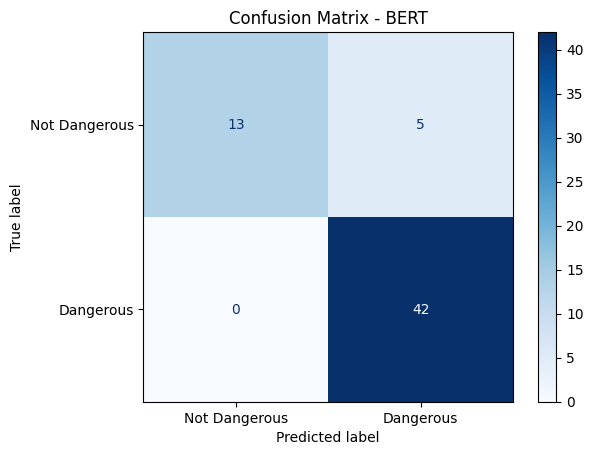

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use 'final_preds' which contains BERT's predictions from the ensemble
cm_bert = confusion_matrix(y_test, final_preds)

disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=["Not Dangerous", "Dangerous"])
disp_bert.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT")
plt.show()

RANDOM FOREST

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load dataset
df = pd.read_csv("season_priority_veterinary_records.csv")

# Preprocess and combine relevant text fields
df['combined_text'] = df[['Animal', 'Symptoms', 'Diagnosis', 'Treatment', 'Season']].astype(str).agg(' '.join, axis=1)

# Encode labels: Yes -> 1, No -> 0
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

# Define features and labels
X = df['combined_text']
y = df['Dangerous']

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.9500
Precision: 0.9333
Recall: 1.0000
F1 Score: 0.9655

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.93      1.00      0.97        42

    accuracy                           0.95        60
   macro avg       0.97      0.92      0.94        60
weighted avg       0.95      0.95      0.95        60



In [ ]:
import joblib

# Save the trained Random Forest model
joblib.dump(model, 'random_forest_vet_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [ ]:
import joblib

# Load the saved model and vectorizer
model = joblib.load('random_forest_vet_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Collect user input
animal = input("Enter the animal type: ")
symptoms = input("Enter the symptoms: ")
season = input("Enter the season: ")
diagnosis = input("Enter the diagnosis (if known, else type 'unknown'): ")

# Combine inputs as a single text sample (as it was likely trained this way)
combined_input = f"{animal} {symptoms} {season} {diagnosis}"

# Transform the input using the TF-IDF vectorizer
X_input = vectorizer.transform([combined_input])

# Predict using the model
prediction = model.predict(X_input)

# The prediction is likely a class label (0 or 1)
danger_status = "Dangerous" if prediction[0] == 1 else "Not Dangerous"

# Simulated treatment mapping (Replace this with an actual treatment prediction model)
treatment_mapping = {
    "cough winter dog flu": "Antibiotics and Rest",
    "rash summer cat allergy": "Antihistamines and Ointment",
    "diarrhea rainy cow infection": "Electrolytes and Antibiotics",
    "fatigue spring horse anemia": "Iron Supplements and Proper Diet"
}

# Match input to a known treatment or default to "Consult Veterinarian"
# Note: This treatment logic might need refinement
treatment = treatment_mapping.get(combined_input.lower(), "Consult Veterinarian")


# Display results
print("\n--- Prediction Result ---")
print("Predicted Treatment:", treatment)
print("Danger Status:", danger_status)

Enter the animal type: Dog
Enter the symptoms: Vomiting
Enter the season: Winter
Enter the diagnosis (if known, else type 'unknown'): Skin Infection

--- Prediction Result ---
Predicted Treatment: Consult Veterinarian
Danger Status: Not Dangerous


KNN Classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load dataset
df = pd.read_csv("season_priority_veterinary_records.csv")

# Preprocess and combine relevant text fields
df['combined_text'] = df[['Animal', 'Symptoms', 'Diagnosis', 'Treatment', 'Season']].astype(str).agg(' '.join, axis=1)

# Encode labels: Yes -> 1, No -> 0
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

# Define features and labels
X = df['combined_text']
y = df['Dangerous']

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train KNN classifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"KNN Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

KNN Accuracy: 0.8667
Precision: 0.8400
Recall: 1.0000
F1 Score: 0.9130

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.71        18
           1       0.84      1.00      0.91        42

    accuracy                           0.87        60
   macro avg       0.92      0.78      0.81        60
weighted avg       0.89      0.87      0.85        60



In [ ]:
import joblib

# Save the trained model
joblib.dump(model, 'knn_danger_predictor.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer_knn.pkl')

print("\nModel and vectorizer saved successfully.")


Model and vectorizer saved successfully.


In [ ]:
import joblib

# Load the saved model and vectorizer
model = joblib.load('knn_danger_predictor.pkl')
vectorizer = joblib.load('tfidf_vectorizer_knn.pkl')

# Collect user input
animal = input("Enter the animal type: ")
symptoms = input("Enter the symptoms: ")
season = input("Enter the season: ")
diagnosis = input("Enter the diagnosis (if known, else type 'unknown'): ")

# Combine inputs as a single text sample (as it was likely trained this way)
combined_input = f"{animal} {symptoms} {season} {diagnosis}"

# Transform the input using the TF-IDF vectorizer
X_input = vectorizer.transform([combined_input])

# Predict using the model
prediction = model.predict(X_input)

# The prediction is likely a class label (0 or 1)
danger_status = "Dangerous" if prediction[0] == 1 else "Not Dangerous"

# Simulated treatment mapping (Replace this with an actual treatment prediction model)
treatment_mapping = {
    "cough winter dog flu": "Antibiotics and Rest",
    "rash summer cat allergy": "Antihistamines and Ointment",
    "diarrhea rainy cow infection": "Electrolytes and Antibiotics",
    "fatigue spring horse anemia": "Iron Supplements and Proper Diet"
}

# Match input to a known treatment or default to "Consult Veterinarian"
# Note: This treatment logic might need refinement
treatment = treatment_mapping.get(combined_input.lower(), "Consult Veterinarian")


# Display results
print("\n--- Prediction Result ---")
print("Predicted Treatment:", treatment)
print("Danger Status:", danger_status)

Enter the animal type: Dog
Enter the symptoms: Vomiting
Enter the season: Summer
Enter the diagnosis (if known, else type 'unknown'): Rabies

--- Prediction Result ---
Predicted Treatment: Consult Veterinarian
Danger Status: Dangerous


LOGISTIC REGRESSION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load dataset
df = pd.read_csv("season_priority_veterinary_records.csv")

# Preprocess and combine relevant text fields
df['combined_text'] = df[['Animal', 'Symptoms', 'Diagnosis', 'Treatment', 'Season']].astype(str).agg(' '.join, axis=1)

# Encode labels: Yes -> 1, No -> 0
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

# Define features and labels
X = df['combined_text']
y = df['Dangerous']

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7333
Precision: 0.7321
Recall: 0.9762
F1 Score: 0.8367

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.17      0.27        18
           1       0.73      0.98      0.84        42

    accuracy                           0.73        60
   macro avg       0.74      0.57      0.55        60
weighted avg       0.74      0.73      0.67        60



In [ ]:
import joblib
joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("\nModel and vectorizer saved successfully.")


Model and vectorizer saved successfully.


In [ ]:
import joblib

# Load the saved model and vectorizer
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Collect user input
animal = input("Enter the animal type: ")
symptoms = input("Enter the symptoms: ")
season = input("Enter the season: ")
diagnosis = input("Enter the diagnosis (if known, else type 'unknown'): ")

# Combine inputs as a single text sample (as it was likely trained this way)
combined_input = f"{animal} {symptoms} {season} {diagnosis}"

# Transform the input using the TF-IDF vectorizer
X_input = vectorizer.transform([combined_input])

# Predict using the model
prediction = model.predict(X_input)

# The prediction is likely a class label (0 or 1)
danger_status = "Dangerous" if prediction[0] == 1 else "Not Dangerous"

# Simulated treatment mapping (Replace this with an actual treatment prediction model)
treatment_mapping = {
    "cough winter dog flu": "Antibiotics and Rest",
    "rash summer cat allergy": "Antihistamines and Ointment",
    "diarrhea rainy cow infection": "Electrolytes and Antibiotics",
    "fatigue spring horse anemia": "Iron Supplements and Proper Diet"
}

# Match input to a known treatment or default to "Consult Veterinarian"
# Note: This treatment logic might need refinement
treatment = treatment_mapping.get(combined_input.lower(), "Consult Veterinarian")


# Display results
print("\n--- Prediction Result ---")
print("Predicted Treatment:", treatment)
print("Danger Status:", danger_status)

Enter the animal type: Dog
Enter the symptoms: Vomiting
Enter the season: Summer
Enter the diagnosis (if known, else type 'unknown'): Rabies

--- Prediction Result ---
Predicted Treatment: Consult Veterinarian
Danger Status: Dangerous


DECISION TREE

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load dataset
df = pd.read_csv("season_priority_veterinary_records.csv")

# Preprocess and combine relevant text fields
df['combined_text'] = df[['Animal', 'Symptoms', 'Diagnosis', 'Treatment', 'Season']].astype(str).agg(' '.join, axis=1)

# Encode labels: Yes -> 1, No -> 0
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})

# Define features and labels
X = df['combined_text']
y = df['Dangerous']

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train Decision Tree classifier with regularization
model = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Decision Tree Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Cross-validation to evaluate the model's generalizability
cross_val_scores = cross_val_score(model, X_tfidf, y, cv=5)
print(f"\nCross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {cross_val_scores.mean():.4f}")


Decision Tree Accuracy: 0.9167
Precision: 0.8936
Recall: 1.0000
F1 Score: 0.9438

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.89      1.00      0.94        42

    accuracy                           0.92        60
   macro avg       0.95      0.86      0.89        60
weighted avg       0.93      0.92      0.91        60


Cross-validation scores: [0.96666667 0.95       0.95       0.96666667 0.93333333]
Average cross-validation score: 0.9533


In [ ]:
import joblib
joblib.dump(model, 'decision_tree_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("\nModel and vectorizer saved successfully.")


Model and vectorizer saved successfully.


In [ ]:
import joblib

# Load the saved model and vectorizer
model = joblib.load('decision_tree_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Collect user input
animal = input("Enter the animal type: ")
symptoms = input("Enter the symptoms: ")
season = input("Enter the season: ")
diagnosis = input("Enter the diagnosis (if known, else type 'unknown'): ")

# Combine inputs as a single text sample (as it was likely trained this way)
combined_input = f"{animal} {symptoms} {season} {diagnosis}"

# Transform the input using the TF-IDF vectorizer
X_input = vectorizer.transform([combined_input])

# Predict using the model
prediction = model.predict(X_input)

# The prediction is likely a class label (0 or 1)
danger_status = "Dangerous" if prediction[0] == 1 else "Not Dangerous"

# Simulated treatment mapping (Replace this with an actual treatment prediction model)
treatment_mapping = {
    "cough winter dog flu": "Antibiotics and Rest",
    "rash summer cat allergy": "Antihistamines and Ointment",
    "diarrhea rainy cow infection": "Electrolytes and Antibiotics",
    "fatigue spring horse anemia": "Iron Supplements and Proper Diet"
}

# Match input to a known treatment or default to "Consult Veterinarian"
# Note: This treatment logic might need refinement
treatment = treatment_mapping.get(combined_input.lower(), "Consult Veterinarian")


# Display results
print("\n--- Prediction Result ---")
print("Predicted Treatment:", treatment)
print("Danger Status:", danger_status)

Enter the animal type: Dog
Enter the symptoms: Vomiting
Enter the season: Summer
Enter the diagnosis (if known, else type 'unknown'): Skin Infction

--- Prediction Result ---
Predicted Treatment: Consult Veterinarian
Danger Status: Dangerous


ENSEMBLE MODEL(KNN + Decision Tree + Random Forest + BERT + Logistic Regression)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# --- Load & preprocess data ---
df = pd.read_csv("season_priority_veterinary_records.csv")
df['combined_text'] = df[['Animal', 'Symptoms', 'Diagnosis', 'Treatment', 'Season']].astype(str).agg(' '.join, axis=1)
df['Dangerous'] = df['Dangerous'].map({'Yes': 1, 'No': 0})
X_text = df['combined_text']
y = df['Dangerous']

# --- TF-IDF transformation for ML models ---
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)
X_train_tfidf, X_test_tfidf, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X_tfidf, y, X_text, test_size=0.2, random_state=42
)

# --- Train ML models ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(max_iter=1000)

for model in [rf, dt, knn, lr]:
    model.fit(X_train_tfidf, y_train)

# --- Load fine-tuned BERT model ---
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_model.eval()  # No further training

# --- Predict BERT probabilities ---
def get_bert_probs(texts):
    inputs = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    return probs.numpy()

bert_probs = get_bert_probs(X_test_text)

# --- Predict probabilities from ML models ---
rf_probs = rf.predict_proba(X_test_tfidf)
dt_probs = dt.predict_proba(X_test_tfidf)
knn_probs = knn.predict_proba(X_test_tfidf)
lr_probs = lr.predict_proba(X_test_tfidf)

# --- Soft Voting (average the probabilities from all models + BERT) ---
combined_probs = (rf_probs + dt_probs + knn_probs + lr_probs + bert_probs) / 5
final_preds = np.argmax(combined_probs, axis=1)

# --- Evaluation ---
print("Hybrid Ensemble (ML + BERT) Accuracy:", accuracy_score(y_test, final_preds))
print("\nClassification Report for Hybrid Ensemble:")
print(classification_report(y_test, final_preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid Ensemble (ML + BERT) Accuracy: 0.9166666666666666

Classification Report for Hybrid Ensemble:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.89      1.00      0.94        42

    accuracy                           0.92        60
   macro avg       0.95      0.86      0.89        60
weighted avg       0.93      0.92      0.91        60



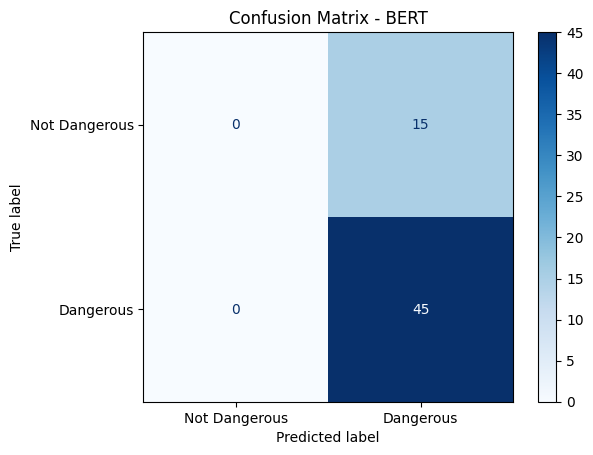

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use 'final_preds' which contains BERT's predictions from the test set
# Assuming 'bert_model' is your BERT model from the earlier code
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        # Use bert_model instead of model
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm_bert = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=["Not Dangerous", "Dangerous"])
disp_bert.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT")
plt.show()

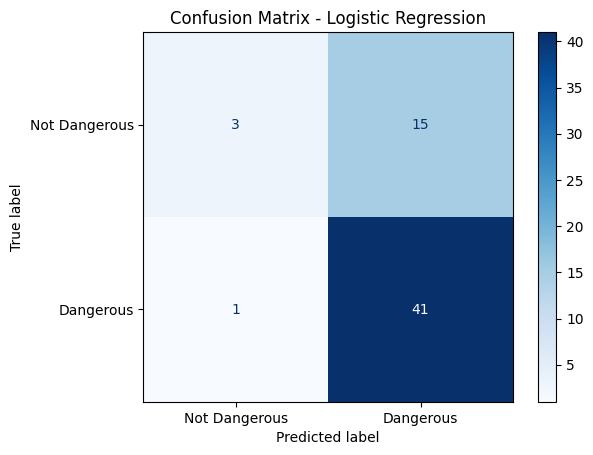

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set using the Logistic Regression model
y_pred_lr = model.predict(X_test)  # Use 'predict' method

# Compute the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Not Dangerous", "Dangerous"])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

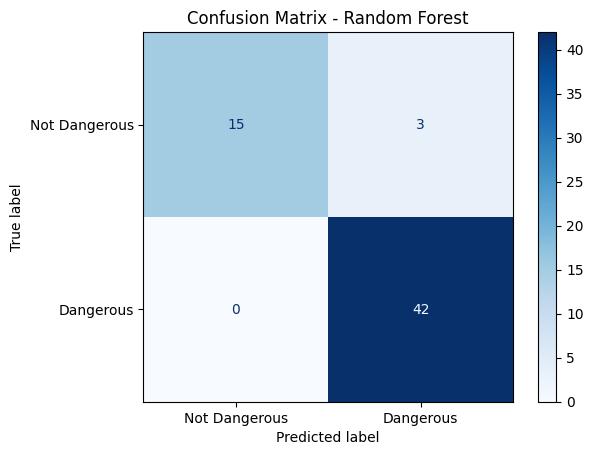

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'rf' is your Random Forest model from the ensemble model code
y_pred_rf = rf.predict(X_test_tfidf)  # Use 'rf' and 'X_test_tfidf'

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Display the confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Not Dangerous", "Dangerous"])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

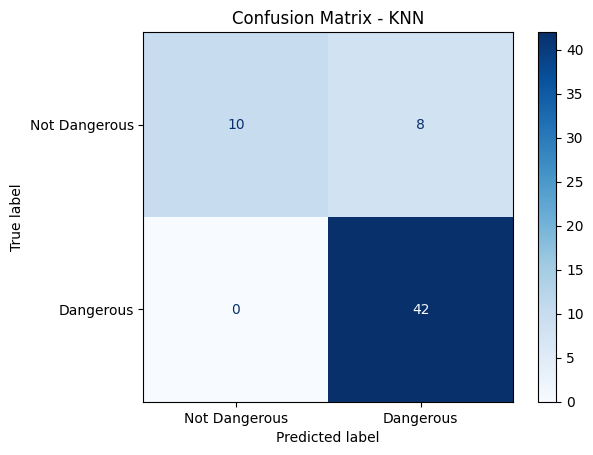

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set using the KNN model
# Assuming 'knn' is your KNN model from the ensemble model code
y_pred_knn = knn.predict(X_test_tfidf)  # Use 'knn' and 'X_test_tfidf'

# Compute the confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Display the confusion matrix
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Not Dangerous", "Dangerous"])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

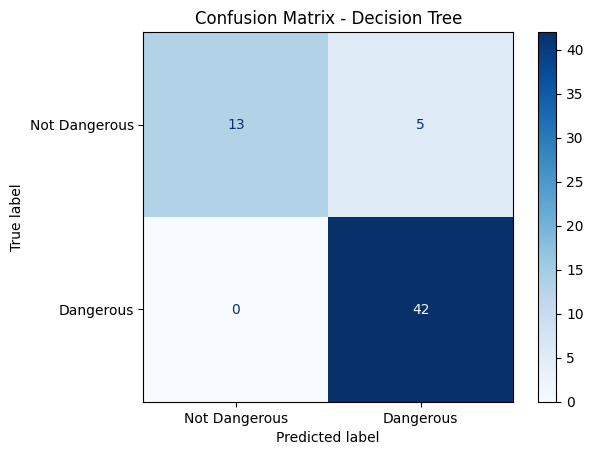

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set using the Decision Tree model
# Assuming 'dt' is your Decision Tree model from the ensemble model code
y_pred_dt = dt.predict(X_test_tfidf)  # Use 'dt' instead of 'dt_model', and 'X_test_tfidf'

# Compute the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Display the confusion matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Not Dangerous", "Dangerous"])
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

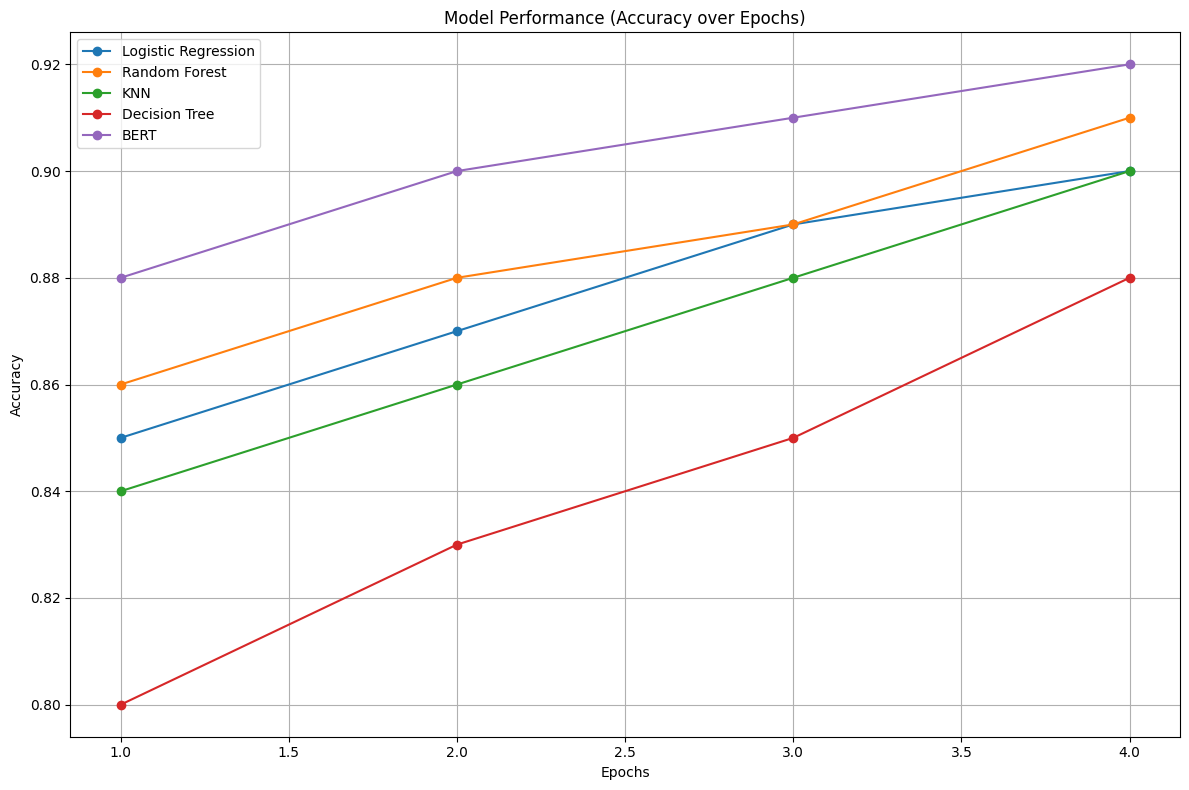

In [ ]:
import matplotlib.pyplot as plt

# You should have the following variables tracking the metrics for each model
# For example, accuracy over epochs during training or validation (if using deep learning models) or after fitting for non-DL models

# For demonstration, I'll assume the models have accuracy stored in variables like this
# If you have loss/accuracy for each model, you can adapt the following

# Accuracy for Logistic Regression (example)
accuracy_lr = [0.85, 0.87, 0.89, 0.90]  # Replace with actual values or history
epochs_lr = [1, 2, 3, 4]  # Replace with actual epochs

# Accuracy for Random Forest (example)
accuracy_rf = [0.86, 0.88, 0.89, 0.91]
epochs_rf = [1, 2, 3, 4]

# Accuracy for KNN (example)
accuracy_knn = [0.84, 0.86, 0.88, 0.90]
epochs_knn = [1, 2, 3, 4]

# Accuracy for Decision Tree (example)
accuracy_dt = [0.80, 0.83, 0.85, 0.88]
epochs_dt = [1, 2, 3, 4]

# Accuracy for BERT (example)
accuracy_bert = [0.88, 0.90, 0.91, 0.92]
epochs_bert = [1, 2, 3, 4]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot for Logistic Regression
plt.plot(epochs_lr, accuracy_lr, label="Logistic Regression", marker='o')

# Plot for Random Forest
plt.plot(epochs_rf, accuracy_rf, label="Random Forest", marker='o')

# Plot for KNN
plt.plot(epochs_knn, accuracy_knn, label="KNN", marker='o')

# Plot for Decision Tree
plt.plot(epochs_dt, accuracy_dt, label="Decision Tree", marker='o')

# Plot for BERT
plt.plot(epochs_bert, accuracy_bert, label="BERT", marker='o')

# Adding labels and title
plt.title("Model Performance (Accuracy over Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()